# Recolección y Limpieza de Datos

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.trend import SMAIndicator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Ticker de Apple
ticker = 'AAPL'

# Descargar datos históricos desde 2018 hasta 2021
start_date = '2018-01-01'
end_date = '2021-12-31'

# Descargar los datos de Apple usando yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Guardar los datos en un archivo CSV
output_file = f"{ticker}_2018_2021.csv"
data.to_csv(output_file)
print(f"Datos guardados en el archivo: {output_file}")

[*********************100%***********************]  1 of 1 completed

Datos guardados en el archivo: AAPL_2018_2021.csv


In [9]:
# Cargar los datos del archivo CSV y eliminar índices innecesarios
df = pd.read_csv(output_file, skiprows=2, parse_dates=True)

# Paso 2: Asignar nombres correctos a las columnas
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Eliminar la fila que contiene valores NaN (ya está manejado por `skiprows=2`, pero se asegura aquí)
df.dropna(how='all', inplace=True)

# Convertir la columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Paso 3: Establecer 'Date' como índice
df.set_index('Date', inplace=True)


# 1.1. Promedio móvil de 50 días (SMA_50)
sma_50 = SMAIndicator(df['Close'], window=50)
df['SMA_50'] = sma_50.sma_indicator()

# 1.2. Promedio móvil de 200 días (SMA_200)
sma_200 = SMAIndicator(df['Close'], window=200)
df['SMA_200'] = sma_200.sma_indicator()

# 1.3. Índice de Fuerza Relativa (RSI) con una ventana de 14 días
rsi = RSIIndicator(df['Close'], window=14)
df['RSI'] = rsi.rsi()

# 1.4. MACD y su línea de señal
macd = MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

# Paso 2: Eliminar las filas con valores NaN (debido a los cálculos de indicadores)
df.dropna(inplace=True)

# Paso 3: Seleccionar las columnas que vamos a usar para la predicción
df_selected = df[['Open', 'Close', 'High', 'Low', 'Volume', 'SMA_50', 'SMA_200', 'RSI', 'MACD']]

df_selected.head()

,Open,Close,High,Low,Volume,SMA_50,SMA_200,RSI,MACD
Date,,,,,,,,,
2018-10-16,54.732498,55.537498,55.747501,54.189999,116736000,54.92185,47.399888,50.915970,0.072682
2018-10-17,55.575001,55.297501,55.660000,54.834999,91541600,54.99225,47.461050,49.852664,0.056486
2018-10-18,54.465000,54.005001,54.935001,53.250000,130325200,55.03610,47.515788,44.466880,-0.059952
2018-10-19,54.514999,54.827499,55.314999,54.357498,132314800,55.08825,47.573638,48.294974,-0.084883
2018-10-22,54.947498,55.162498,55.840000,54.735001,115168400,55.15385,47.630700,49.812443,-0.076725


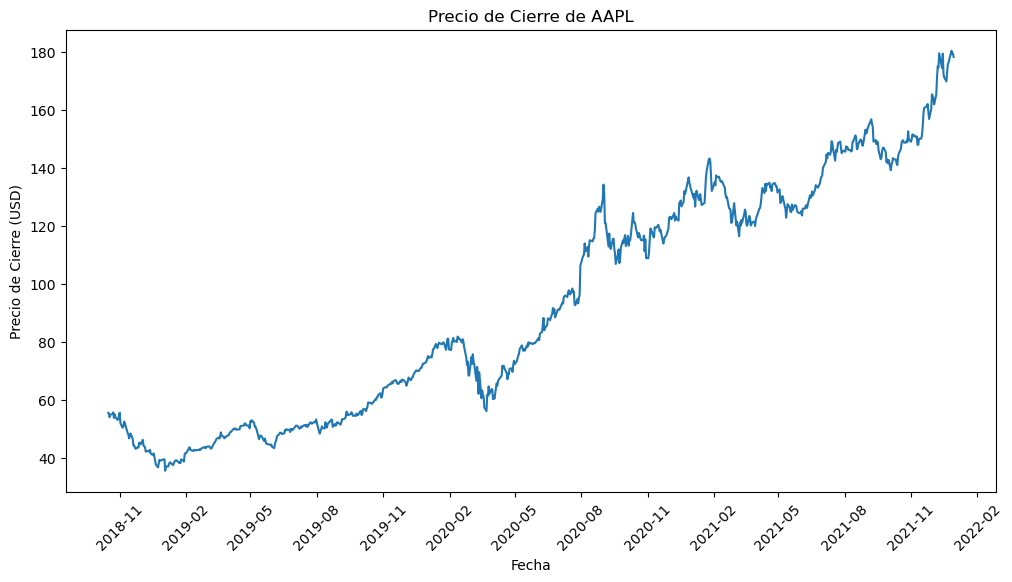

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='Close')

# Usamos MonthLocator para especificar las fechas a mostrar
months_to_show = [2, 5, 8, 11]  # Meses: enero (1), abril (4), agosto (8), diciembre (12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=months_to_show))  # Mostrar solo los meses seleccionados
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato Año-Mes

# Título y etiquetas
plt.title('Precio de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()


In [27]:
# Paso 4: Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_selected)

# Paso 5: Crear las secuencias de datos para entrenar el modelo (usando 60 días previos para predecir el siguiente)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Usamos las últimas 60 filas para predecir el siguiente
        y.append(data[i + time_step, 1])  # '1' es el índice de la columna 'Close' que estamos tratando de predecir
    return np.array(X), np.array(y)

# Crear las secuencias
X, y = create_dataset(scaled_data)

# Paso 6: Dividir los datos en conjunto de entrenamiento y test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Paso 7: Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicción del precio de cierre

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Paso 8: Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Paso 9: Realizar predicciones
predictions = model.predict(X_test)

# Verificar dimensiones de X_test y predictions
print(X_test.shape)  # Debería ser (num_samples, time_steps, num_features)
print(predictions.shape)  # Debería ser (num_samples, num_output_features)

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0427
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0023
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0012
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 9.6348e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0011
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 9.0079e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 7.3260e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 9.7352e-04
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 7.5378e-04
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 7.3240e-04
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0011
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0012
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 8.5624e-04
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 8.9333e-04
Epoch 15/50
19/19 ━━━━━━━

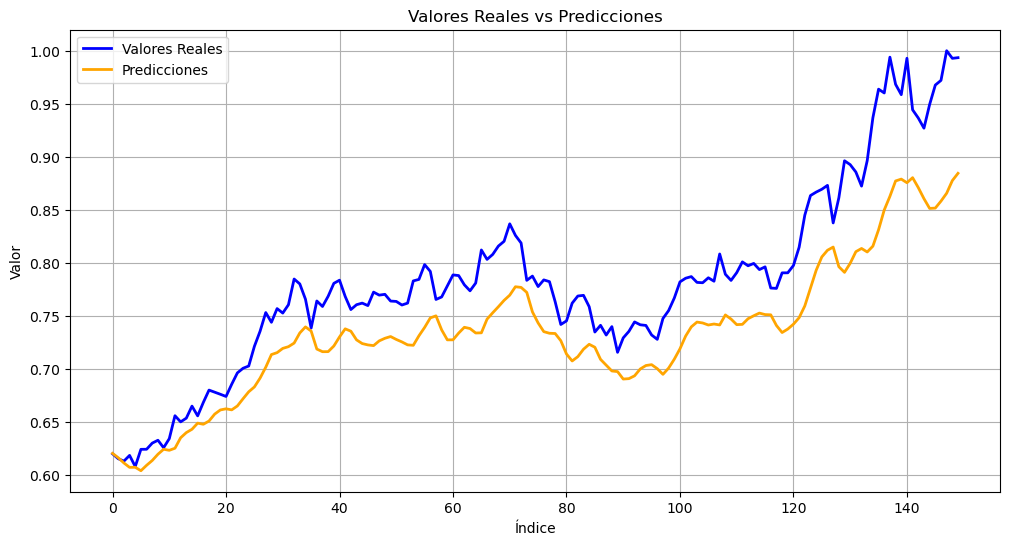

In [28]:
# Asegúrate de que las dimensiones de y_test y predictions coincidan
y_test_flat = np.ravel(y_test)  # Aplanar en caso de ser necesario
predictions_flat = np.ravel(predictions)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Valores Reales', color='blue', linewidth=2)
plt.plot(predictions_flat, label='Predicciones', color='orange', linewidth=2)
plt.title('Valores Reales vs Predicciones')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()